<a href="https://colab.research.google.com/github/mgarbanzo/AgrometeoUCR/blob/main/C%C3%B3digo_de_muestra_para_Laboratorio_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

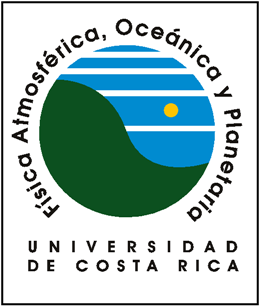

Curso: Agrometeorología  
Profesores: Dr. Marcial Garbanzo Salas, Dra. Ana María Durán Quesada  
Programa de Bachillerato en Meteorología  
Escuela de Física  
Universidad de Costa Rica  

***


# Instalación de librerías necesarias para ejecución de programas y cálculo del NDVI


In [1]:
!pip install --upgrade pip
!pip install netcdf4
!pip uninstall -y shapely imgaug
!pip install cartopy
!pip install shapely --no-binary shapely --force
!pip install boto3

Found existing installation: Shapely 1.7.1
Uninstalling Shapely-1.7.1:
  Successfully uninstalled Shapely-1.7.1
  Using cached Shapely-1.7.1-cp37-cp37m-manylinux1_x86_64.whl (1.0 MB)
  Using cached Shapely-1.7.1.tar.gz (383 kB)
Skipping wheel build for shapely, due to binaries being disabled for it.
  Attempting uninstall: shapely
    Found existing installation: Shapely 1.7.1
    Uninstalling Shapely-1.7.1:
      Successfully uninstalled Shapely-1.7.1
    Running setup.py install for shapely ... done


Se puede utilizar las funciones definidas dentro de utilities.py para simplificar algunos pasos del proceso.

In [2]:
!wget -c https://www.dropbox.com/s/i8j1g9xg1g7o56l/utilities.py

--2021-06-02 14:31:49--  https://www.dropbox.com/s/i8j1g9xg1g7o56l/utilities.py
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/i8j1g9xg1g7o56l/utilities.py [following]
--2021-06-02 14:31:49--  https://www.dropbox.com/s/raw/i8j1g9xg1g7o56l/utilities.py
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc2265d9d673f98a12f13c369141.dl.dropboxusercontent.com/cd/0/inline/BPpw6F2RhBaFg7CUjq8ti0WjOBTds_dwthie8eAtCUUu3oKXnJeYLoDzlsSoF7X-a2xFx7Znz015rQW02Pv9V4HcL30OiYyfA0kjFd1QLNhqax1oav0HJmVChgKlBZ18NDa5bh7tCAKzFpaYv9Am0Q9d/file# [following]
--2021-06-02 14:31:50--  https://uc2265d9d673f98a12f13c369141.dl.dropboxusercontent.com/cd/0/inline/BPpw6F2RhBaFg7CUjq8ti0WjOBTds_dwthie8eAtCUUu3oKXnJeYLoDzlsSoF7X-a2xFx7Znz015rQW02Pv9V4HcL3

# Graficación de datos de NDVI para Costa Rica

(397, 400) (397, 400)


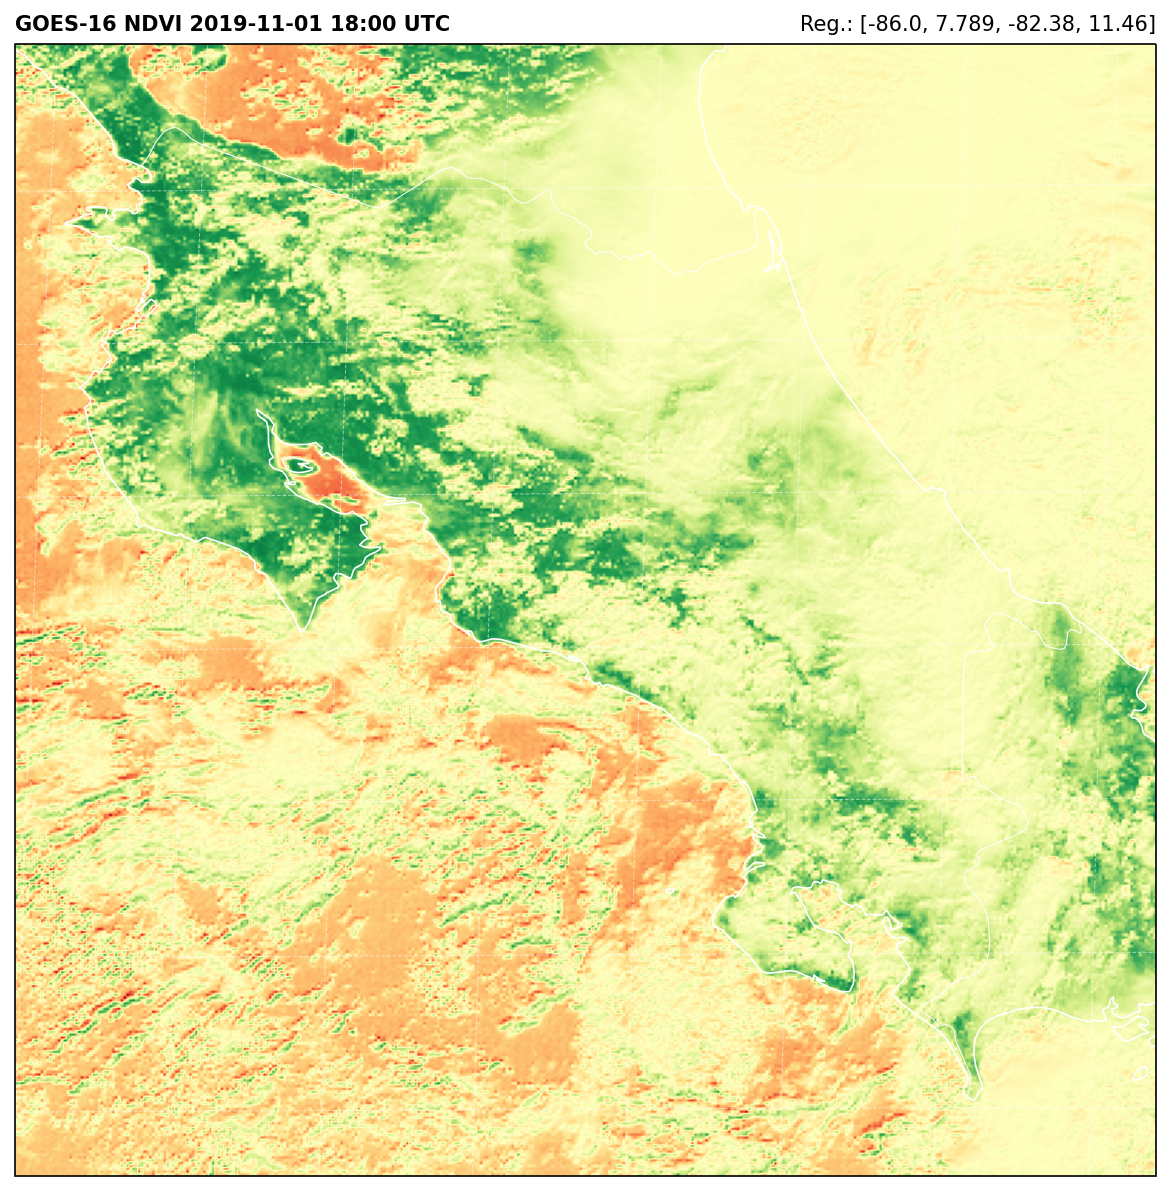

In [9]:
# Training: Python and GOES-R Imagery: Script 13 - Cropping the Full Disk and Creating an RGB
#-----------------------------------------------------------------------------------------------------------
# Required modules
from netCDF4 import Dataset              # Read / Write NetCDF4 files
import matplotlib.pyplot as plt          # Plotting library
from datetime import datetime            # Basic Dates and time types
import cartopy, cartopy.crs as ccrs      # Plot maps
import numpy as np                       # Scientific computing with Python
import os                                # Miscellaneous operating system interfaces
from utilities import download_CMI       # Our own utilities
from utilities import geo2grid, latlon2xy, convertExtent2GOESProjection      # Our own utilities
#-----------------------------------------------------------------------------------------------------------
# Input and output directories
input = "/content/Samples"; os.makedirs(input, exist_ok=True)
output = "/content/Output"; os.makedirs(output, exist_ok=True)

# Datetime to process
yyyymmddhhmn = '201911011800'

# Desired extent
extent = [-86.0, 7.789, -82.38, 11.46] # Min lon, Max lon, Min lat, Max lat

#-----------------------------------------------------------------------------------------------------------
# Download the necessary bands from AWS
file_ch02 = download_CMI(yyyymmddhhmn, 2, input)
file_ch03 = download_CMI(yyyymmddhhmn, 3, input)

#-----------------------------------------------------------------------------------------------------------
# Open the GOES-R images
file_ch02 = Dataset(f'{input}/{file_ch02}.nc')
file_ch03 = Dataset(f'{input}/{file_ch03}.nc')
#-----------------------------------------------------------------------------------------------------------                   
# Convert lat/lon to grid-coordinates
lly, llx = geo2grid(extent[1], extent[0], file_ch02)
ury, urx = geo2grid(extent[3], extent[2], file_ch02)

# Get the pixel values
data_ch02 = file_ch02.variables['CMI'][ury:lly, llx:urx][::2 ,::2] 
#-----------------------------------------------------------------------------------------------------------
# Convert lat/lon to grid-coordinates
lly, llx = geo2grid(extent[1], extent[0], file_ch03)
ury, urx = geo2grid(extent[3], extent[2], file_ch03)

# Get the pixel values
data_ch03 = file_ch03.variables['CMI'][ury:lly, llx:urx][::1 ,::1] 
#-----------------------------------------------------------------------------------------------------------
print(np.shape(data_ch03),np.shape(data_ch02))
# Make the arrays equal size

cordX = np.shape(data_ch02)[0], np.shape(data_ch03)[0]
cordY = np.shape(data_ch02)[1], np.shape(data_ch03)[1]

minvalX = np.array(cordX).min()
minvalY = np.array(cordY).min()

data_ch02 = data_ch02[0:minvalX, 0:minvalY]
data_ch03 = data_ch03[0:minvalX, 0:minvalY]
#-----------------------------------------------------------------------------------------------------------
# Compute data-extent in GOES projection-coordinates
img_extent = convertExtent2GOESProjection(extent)              
#-----------------------------------------------------------------------------------------------------------

NDVI = (data_ch03 - data_ch02)/(data_ch03 + data_ch02)

#-----------------------------------------------------------------------------------------------------------
# Choose the plot size (width x height, in inches)
plt.figure(figsize=(10,10), dpi=150)

# Use the Geostationary projection in cartopy
ax = plt.axes(projection=ccrs.Geostationary(central_longitude=-75.0, satellite_height=35786023.0))

# Plot the image
colormap = "RdYlGn"
img = ax.imshow(NDVI, origin='upper', extent=img_extent, cmap=colormap)

# Add coastlines, borders and gridlines
ax.coastlines(resolution='10m', color='white', linewidth=0.8)
ax.add_feature(cartopy.feature.BORDERS, edgecolor='white', linewidth=0.5)
ax.gridlines(color='white', alpha=0.5, linestyle='--', linewidth=0.5)

# Extract date
date = (datetime.strptime(file_ch02.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ'))

# Add a title
plt.title('GOES-16 NDVI ' + date.strftime('%Y-%m-%d %H:%M') + ' UTC', fontweight='bold', fontsize=10, loc='left')
plt.title('Reg.: ' + str(extent) , fontsize=10, loc='right')
#-----------------------------------------------------------------------------------------------------------
# Save the image
plt.savefig(f'{output}/NDVI.png', bbox_inches='tight', pad_inches=0, dpi=300)
            
# Show the image
plt.show()

# Extracción del valor NDVI para una ubicación de interés

In [10]:
from netCDF4 import Dataset              # Funciones para archivos tipo NetCDF4
import matplotlib.pyplot as plt          # Funciones de graficación
from datetime import datetime            # Funciones para manipulación y uso de tiempo
import cartopy, cartopy.crs as ccrs      # Graficación de mapas
import numpy as np                       # Funciones para arreglos numéricos
import os                                # Interacción con el sistema operativo
from utilities import download_CMI       # Funciones del archivo utilities.py
from utilities import geo2grid, latlon2xy, convertExtent2GOESProjection      # Funciones del archivo utilities.py
#-----------------------------------------------------------------------------------------------------------
# Directorio para colocar los archivos descargados
input = "/content/Samples"; os.makedirs(input, exist_ok=True)

# Fecha y hora de interés
yyyymmddhhmn = '201911011800'

# Extensión de interés (Debe contener las coordenadas que se desean extraer)
extent = [-86.0, 7.789, -82.38, 11.46] # Min lon, Min lat, Max lon, Max lat

#-----------------------------------------------------------------------------------------------------------
# Descarga de los archivos desde AWS
file_ch02 = download_CMI(yyyymmddhhmn, 2, input)
file_ch03 = download_CMI(yyyymmddhhmn, 3, input)

#-----------------------------------------------------------------------------------------------------------
# Lectura de metadatos de los archivos
file_ch02 = Dataset(f'{input}/{file_ch02}.nc')
file_ch03 = Dataset(f'{input}/{file_ch03}.nc')
#-----------------------------------------------------------------------------------------------------------                   
# Conversión de coordenadas a grillas
lly, llx = geo2grid(extent[1], extent[0], file_ch02)
ury, urx = geo2grid(extent[3], extent[2], file_ch02)

# Lectura de datos de canal 2
data_ch02 = file_ch02.variables['CMI'][ury:lly, llx:urx][::2 ,::2] 
#-----------------------------------------------------------------------------------------------------------
# Conversión de coordenadas a grillas
lly, llx = geo2grid(extent[1], extent[0], file_ch03)
ury, urx = geo2grid(extent[3], extent[2], file_ch03)

# Lectura de datos de canal 3
data_ch03 = file_ch03.variables['CMI'][ury:lly, llx:urx][::1 ,::1] 

# Cálculo del NDVI para la región de interés
NDVI = (data_ch03 - data_ch02)/(data_ch03 + data_ch02)

# Definición del lugar para extracción del valor de NDVI
AI_LAT = 9.725457
AI_LON = -82.888128

LOCATION = geo2grid(AI_LAT, AI_LON, file_ch03)
Mcoordinates = LOCATION[0]-ury, LOCATION[1]-llx

print(yyyymmddhhmn, NDVI[Mcoordinates])

File /content/Samples/OR_ABI-L2-CMIPF-M6C02_G16_s20193051800209_e20193051809517_c20193051809596.nc exists
File /content/Samples/OR_ABI-L2-CMIPF-M6C03_G16_s20193051800209_e20193051809517_c20193051810017.nc exists
201911011800 0.050178356
